## Set Up Environment

In [2]:
pip install -U scikit-learn scipy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
!export ARCHFLAGS="-arch arm64"

In [4]:
!python setup.py clean --all
!python 'setup.py' install
!python 'setup.py' build

running clean
removing 'build/temp.macosx-10.9-x86_64-3.9' (and everything under it)
removing 'build/lib.macosx-10.9-x86_64-3.9' (and everything under it)
removing 'build/bdist.macosx-10.9-x86_64' (and everything under it)
'build/scripts-3.9' does not exist -- can't clean it
running install
running bdist_egg
running egg_info
writing data_depth.egg-info/PKG-INFO
writing dependency_links to data_depth.egg-info/dependency_links.txt
writing requirements to data_depth.egg-info/requires.txt
writing top-level names to data_depth.egg-info/top_level.txt
reading manifest file 'data_depth.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'data_depth.egg-info/SOURCES.txt'
installing library code to build/bdist.macosx-10.9-x86_64/egg
running install_lib
running build_py
creating build/lib.macosx-10.9-x86_64-3.9
creating build/lib.macosx-10.9-x86_64-3.9/depth
copying depth/conf.py -> build/lib.macosx-10.9-x86_64-3.9/depth
copying depth/__init__.py -> build/lib.macos

11 warnings generated.
g++ -Wl, -shared -lstdc++ -arch x86_64 build/temp.macosx-10.9-x86_64-3.9/depth/src/depth_wrapper.o -o build/lib.macosx-10.9-x86_64-3.9/depth_wrapper.cpython-39-darwin.so -rdynamic -std=c++14 -fPIC
ld: warning: ignoring duplicate libraries: '-lc++'
copying build/lib.macosx-10.9-x86_64-3.9/ddalpha.cpython-39-darwin.so -> build/bdist.macosx-10.9-x86_64/egg
copying build/lib.macosx-10.9-x86_64-3.9/depth_wrapper.cpython-39-darwin.so -> build/bdist.macosx-10.9-x86_64/egg
copying build/lib.macosx-10.9-x86_64-3.9/depth/multivariate/MCD.py -> build/bdist.macosx-10.9-x86_64/egg/depth/multivariate
copying build/lib.macosx-10.9-x86_64-3.9/depth/multivariate/L2.rst -> build/bdist.macosx-10.9-x86_64/egg/depth/multivariate
copying build/lib.macosx-10.9-x86_64-3.9/depth/multivariate/Potential.rst -> build/bdist.macosx-10.9-x86_64/egg/depth/multivariate
copying build/lib.macosx-10.9-x86_64-3.9/depth/multivariate/plot.py -> build/bdist.macosx-10.9-x86_64/egg/depth/multivariate
cop

running build
running build_py
running egg_info
writing data_depth.egg-info/PKG-INFO
writing dependency_links to data_depth.egg-info/dependency_links.txt
writing requirements to data_depth.egg-info/requires.txt
writing top-level names to data_depth.egg-info/top_level.txt
reading manifest file 'data_depth.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'data_depth.egg-info/SOURCES.txt'
running build_ext


In [5]:
!find build/ -name "*.so"

build//bdist.macosx-10.9-x86_64/egg/ddalpha.cpython-39-darwin.so
build//bdist.macosx-10.9-x86_64/egg/depth_wrapper.cpython-39-darwin.so
build//lib.macosx-10.9-x86_64-3.9/ddalpha.cpython-39-darwin.so
build//lib.macosx-10.9-x86_64-3.9/depth_wrapper.cpython-39-darwin.so


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from depth.multivariate import *

## Generate Toy 2D Dataset
We use the multivariate_normal function in numpy, using the speficiations given in the anomaly detection paper.

In [7]:
mean1 = (1, 1)
mean2 = (-3.181, -0.222)
cov1 = [[1, 1], [1, 2]]
cov2 = [[i / 36 for i in j] for j in cov1]

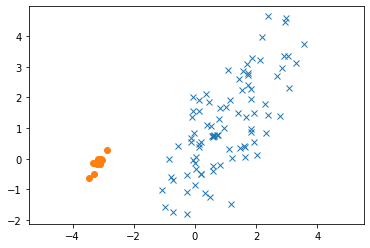

In [8]:
# use fixed random seed for reproducable results
rng = np.random.default_rng(322180440709489274700185804004290683059)
x, y = rng.multivariate_normal(mean1, cov1, 90).T
anom_x, anom_y = rng.multivariate_normal(mean2, cov2, 10).T

# Combine x and anom_x
combined_x = np.concatenate([x, anom_x])
combined_y = np.concatenate([y, anom_y])

# Plot the combined dataset
plt.plot(x, y, 'x')
plt.plot(anom_x, anom_y, 'o')
plt.axis('equal')
plt.show()

In [9]:
# compute combined dataset
combined_data = np.column_stack((combined_x, combined_y))
print(combined_x.shape, combined_data.shape)

(100,) (100, 2)


## Compute Data Depth using different definitions

In [10]:
# compute projection depth for each point in the combined dataset
projection_depths = projection(combined_x, combined_data)
halfspace_depths = halfspace(combined_x, combined_data)
##TODO
projection_depths

array([0.38109896])

In [11]:
# compute Mahalanobis depth for each point in the combined dataset
mahalanobis_depths = mahalanobis(combined_x, combined_data)

In [12]:
# compute simplicial depth for each point in the combined dataset
simplicial_depths = simplicial(combined_x, combined_data)
simplicial_depths

array([0.0844898 , 0.07769944, 0.16310451, 0.        , 0.11363018,
       0.10951144, 0.        , 0.05196042, 0.        , 0.07186147,
       0.01588126, 0.22897959, 0.        , 0.04534323, 0.00178108,
       0.        , 0.13485467, 0.04251082, 0.01280148, 0.12565244,
       0.04380952, 0.0707483 , 0.01888683, 0.05050093, 0.22325294,
       0.06787879, 0.10217687, 0.        , 0.05548547, 0.08655535,
       0.        , 0.12604824, 0.09596784, 0.17559678, 0.18414348,
       0.16087817, 0.03735312, 0.25079777, 0.04326531, 0.02837353,
       0.08829932, 0.2490167 , 0.00839827, 0.02822511, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.15478046, 0.15478046, 0.15478046, 0.15478046,
       0.15478046, 0.15478046, 0.15478046, 0.15478046, 0.15478046,
       0.15478046, 0.15478046, 0.15478046, 0.15478046, 0.15478046,
       0.15478046, 0.15478046, 0.15478046, 0.15478046, 0.15478046,
       0.15478046, 0.15478046, 0.15478046, 0.15478046, 0.15478

In [13]:
# compute convex hull peeling depth for each point in the combined dataset
convex_hull_depths = qhpeeling(combined_x, combined_data)

## Plot depth contour plots for each definition

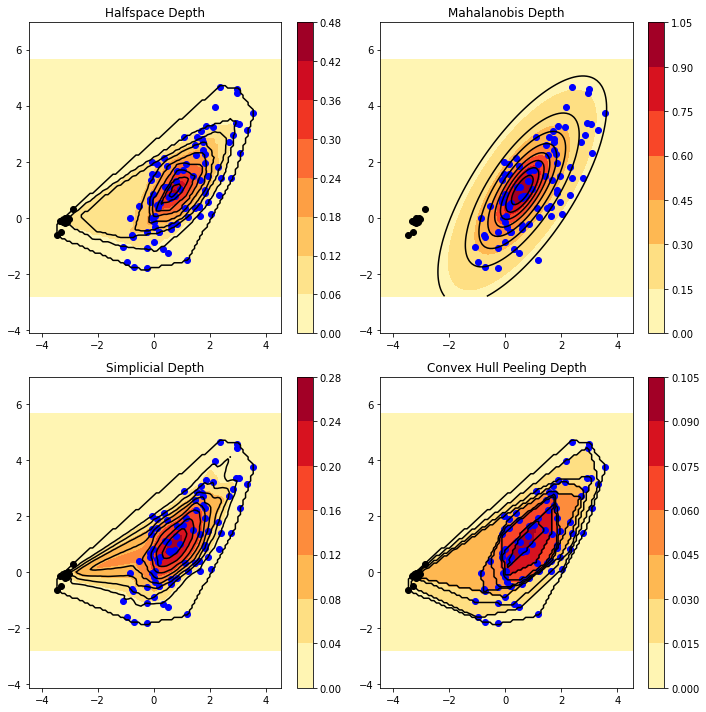

In [14]:
# Function to plot depth contours
def plot_depth_contours(ax, depth_function, title):
    # Create grid for plotting
    grid_x, grid_y = np.mgrid[combined_x.min()-1:combined_x.max()+1:100j, combined_y.min()-1:combined_y.max()+1:100j]
    grid = np.column_stack([grid_x.ravel(), grid_y.ravel()])
    
    # Compute depth on the grid
    grid_depths = depth_function(grid, combined_data)
    grid_depths = grid_depths.reshape(grid_x.shape)
    
    # Plot depth contours
    contour = ax.contourf(grid_x, grid_y, grid_depths, cmap="YlOrRd")
    ax.contour(grid_x, grid_y, grid_depths, colors='k', levels=np.linspace(grid_depths.min(), grid_depths.max(), 10))
    ax.scatter(x, y, c='blue', label='Data points')
    ax.scatter(anom_x, anom_y, c='black', label='Data points')
    
    # Add a color bar
    fig.colorbar(contour, ax=ax, orientation='vertical')

    ax.set_title(title)
    ax.axis('equal')

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

plot_depth_contours(axs[0, 0], halfspace, "Halfspace Depth")
plot_depth_contours(axs[0, 1], mahalanobis, "Mahalanobis Depth")
plot_depth_contours(axs[1, 0], simplicial, "Simplicial Depth")
plot_depth_contours(axs[1, 1], qhpeeling, "Convex Hull Peeling Depth")

plt.tight_layout()
plt.show()

## Generate Toy 3D Datasets

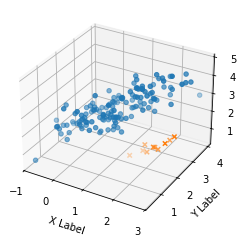

In [48]:
from mpl_toolkits.mplot3d import Axes3D
from numpy.random import RandomState

# fixed random seed for reproducible results
prng = RandomState(10000202)

mean = (1, 2, 3)
anom_mean = (2, 2.5, 1)

# random matrix for covariance
random_matrix = prng.rand(3, 3)
# ensuring that the matrix is symmetric positive-semidefinite
cov = np.dot(random_matrix, random_matrix.T)
cov += np.eye(3) * 1e-6
anom_cov = cov / 12

pts = rng.multivariate_normal(mean, cov, size=140).T
anom_pts = rng.multivariate_normal(anom_mean, anom_cov, size=10).T

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pts[0], pts[1], pts[2], marker='o')
ax.scatter(anom_pts[0], anom_pts[1], anom_pts[2], marker='x')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

plt.show()

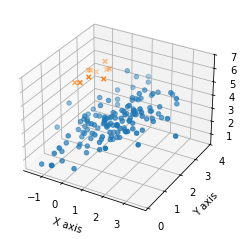

In [72]:
prng = RandomState(666888999)

mean = (1, 2, 3)
anom_mean = (0, 2, 6)

# random matrix for covariance
random_matrix = prng.rand(3, 3)
# ensuring that the matrix is symmetric positive-semidefinite
cov = np.dot(random_matrix, random_matrix.T)
cov += np.eye(3) * 1e-6
anom_cov = cov / 5

pts = rng.multivariate_normal(mean, cov, size=140).T
anom_pts = rng.multivariate_normal(anom_mean, anom_cov, size=10).T

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pts[0], pts[1], pts[2], marker='o')
ax.scatter(anom_pts[0], anom_pts[1], anom_pts[2], marker='x')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

plt.show()